In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
import string
import numpy as np
import os
import glob

import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

import wordcloud
from wordcloud import WordCloud, STOPWORDS 
from textblob import Word
from collections import Counter

from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import load_model

from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package wordnet to /home/rlb4/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/rlb4/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/rlb4/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [13]:
train_df = pd.read_csv("../data/train_data.csv", encoding = "ISO-8859-1")

In [3]:
stopwords_lstm = pd.read_csv('../LSTM/LSTM_details/stopwords_lstm.csv')

def preprocess(text):
    
    stopwords = set(STOPWORDS)
    
    # Appending new airline related stop-words
    stopwords.update([str(i).lower() for i in stopwords_lstm.name]) 
    
    # Filter for mentions
    mentions_filter = re.compile(r'(?<=\@)(\w+)')
    
    # Filter for hash-tags
    hashtags_filter = re.compile(r'(?<=\#)(\w+)')
    
    # Filter for flights numbers
    flight_numbers = re.compile(r'(flt\d*)')
    
    # Finding all mentions
    all_mentions = mentions_filter.findall(text.lower())
    
    # Finding all hash-tags
    all_hashtag = hashtags_filter.findall(text.lower())
    
    # Finding all hash-tags
    all_flights = flight_numbers.findall(text.lower())
    
    word_lemmatize = WordNetLemmatizer()
    
    # Lemmatizing 
    def lemm_tokens(tokens, lemmatize):
        lemmatized = []
        for item in tokens:
            lemmatized.append(lemmatize.lemmatize(item,'v'))
        return lemmatized
    
    # De-emojify tweets to text
    def deEmojify(inputString):
        return inputString.encode('ascii', 'ignore').decode('ascii')
    
    text = deEmojify(text)
    soup = BeautifulSoup(text)
    text = soup.get_text()
    
    # Removing punctuation
    punc_text = [x.lower() for x in text if x not in string.punctuation]
    text = "".join(punc_text)
    
    # Tokenize words
    word_tokens = nltk.word_tokenize(text)
    
    # Keeping the words with length between 2 and 15
    filtered_tokens = [x for x in word_tokens if len(x)>2 and len(x)<15]
    
    # Filter tokens
    tokens = lemm_tokens(filtered_tokens, word_lemmatize)
    all_tokens = [i for i in tokens if (i not in stopwords) and (i not in all_mentions) 
                  and (i not in all_hashtag) and (i not in all_flights) and (not i.isdigit())]
    
    return all_tokens

In [4]:
train_df = train_df.dropna(subset=['text'])

In [5]:
train_df['text_tokenized']=train_df['text'].astype("string").map(preprocess)

In [6]:
train_df = train_df.reset_index(drop=True)

In [7]:
def remove_if_empty(df):
    empty_ids = df['text_tokenized'].map(lambda i: len(i)) > 0
    idsToDelete = []
    for i in range(len(empty_ids)):
        if not empty_ids[i]:
            idsToDelete.append(i)
    for currentID in idsToDelete:
        df = df.drop(df[df.index == currentID].index[0])
    return df

In [8]:
print(train_df.shape)
train_df = remove_if_empty(train_df)
print(train_df.shape)

(30944, 8)
(30834, 8)


In [10]:
lb=LabelEncoder()
train_df['airline_sentiment'] = lb.fit_transform(train_df['airline_sentiment'])

tokenizer = Tokenizer(num_words=2000, split=' ') 
tokenizer.fit_on_texts(train_df['text_tokenized'].values)
X = tokenizer.texts_to_sequences(train_df['text'].values)
X = pad_sequences(X)

model = Sequential()
model.add(Embedding(2000, 128, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(196, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

#Splitting the data into training and testing
y=pd.get_dummies(train_df['airline_sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

batch_size=32
model.fit(X_train, y_train, epochs = 10, validation_data = (X_test, y_test),batch_size=batch_size, verbose = 'auto')
model.evaluate(X_test,y_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 22, 128)           256000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 22, 128)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 196)               254800    
                                                                 
 dense (Dense)               (None, 3)                 591       
                                                                 
Total params: 511,391
Trainable params: 511,391
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
771/771 [==============================] - 18s 21ms/step - loss: 0.6657 - accuracy: 0.7205 - val_los

[0.45071351528167725, 0.8386573791503906]

In [ ]:
from pathlib import Path

model_structure = model.to_json()
f = Path("LSTM_details/model_structure.json")
f.write_text(model_structure)

model.save_weights("LSTM_details/model_weights.h5")

model.save('LSTM_details/model.h5')

max_length = str(len(X_train[0]))
f = Path("LSTM_details/X_train_max_length.txt")
f.write_text(max_length)

train_df = train_df.reset_index(drop=True)
train_df[['text_tokenized']].to_csv("LSTM_details/train_text_vals.csv")

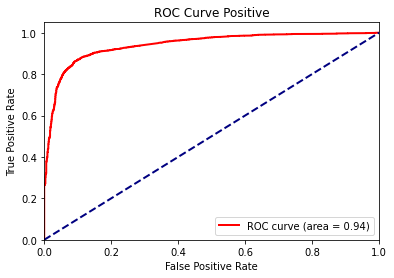

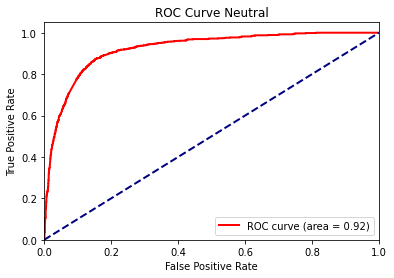

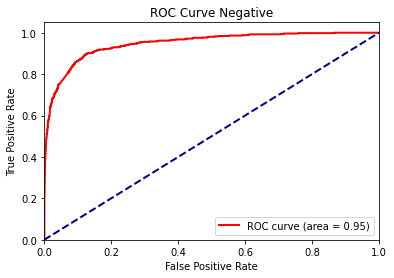

In [12]:
# ROC Curve Plotting
from sklearn.metrics import roc_curve, auc

fpr, tpr, roc_auc = {}, {}, {}

y_test = y_test.to_numpy()
y_score = model.predict(X_test)

label = ['Positive','Neutral','Negative']
n_classes = 3 

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

for nc in range(3):
    plt.figure()
    plt.plot( fpr[nc], tpr[nc],
        color="red", lw=2, label="ROC curve (area = %0.2f)" % roc_auc[nc])
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve "+label[nc])
    plt.legend(loc="lower right")
    plt.show()